# Running a multi-member hydrological ensemble on the Raven Server

Here we use birdy's WPS client to launch the GR4JCN hydrological model using two sets of parameters.

In [1]:
from birdy import WPSClient

from example_data import TESTDATA
import datetime as dt
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os

# Set environment variable RAVEN_WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get("RAVEN_WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")
wps = WPSClient(url)

In [2]:
# The model parameters for gr4jcn and hmets. 
# It's not possible at the moment to pass multiple parameters as a nested list due to the WPSClient limitations. 
# Use a list of strings instead. 
params = ['0.529, -3.396, 407.29, 1.072, 16.9, 0.947', '0.4, -3.96, 307.29, 1.072, 16.9, 0.947']

# Forcing files. Raven uses the same forcing files for all and extracts the information it requires for each model.
ts=TESTDATA['raven-gr4j-cemaneige-nc-ts']

# Model configuration parameters.
config = dict(
    start_date=dt.datetime(2000, 1, 1),
    end_date=dt.datetime(2002, 1, 1),
    area=4250.6,
    name="Salmon",
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    )

# Launch the WPS to get the multi-model results.  Note the "gr4jcn" and "hmets" keys.
resp = wps.raven_gr4j_cemaneige(ts=str(ts), params=params, **config) 

The `hydrograph` and `storage` output are netCDF files where the simulations are concatenated along the `params` dimension. The `solution` output is a list of `rvc` files, and the `diagnostics` a list of performance metrics comparing simulations with observations. 

In [3]:
[hydrograph, storage, solution, diagnostics, rv] = resp.get(asobj=True)
hydrograph

<xarray.Dataset>
Dimensions:     (nbasins: 1, params: 2, time: 732)
Coordinates:
    basin_name  (nbasins) object ...
  * time        (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2002-01-01
Dimensions without coordinates: nbasins, params
Data variables:
    q_obs       (time, nbasins) float64 ...
    q_in        (time, nbasins) float64 ...
    precip      (time) float64 ...
    q_sim       (params, time, nbasins) float64 ...
Attributes:
    Conventions:          CF-1.6
    featureType:          timeSeries
    history:              Created on 2020-03-09 15:55:07 by Raven
    description:          Standard Output
    title:                Simulated river discharge
    references:           Craig J.R. and the Raven Development Team Raven use...
    comment:              Raven Hydrological Framework version 2.9 rev#177
    model_id:             gr4jcn
    time_frequency:       day
    time_coverage_start:  2000-01-01 00:00:00
    time_coverage_end:    2002-01-01 00:00:00

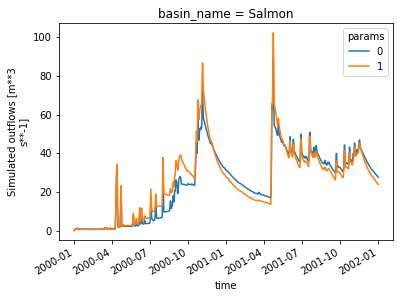

In [4]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


hydrograph.q_sim.isel(nbasins=0).plot.line(hue='params')

In [5]:
print(diagnostics)

['observed data series,filename,DIAG_NASH_SUTCLIFFE,DIAG_RMSE,\nHYDROGRAPH,/tmp/pywps_process_fdil183e/Salmon-River-Near-Prince-George_meteo_daily.nc,-0.0371048,36.562,\n', 'observed data series,filename,DIAG_NASH_SUTCLIFFE,DIAG_RMSE,\nHYDROGRAPH,/tmp/pywps_process_fdil183e/Salmon-River-Near-Prince-George_meteo_daily.nc,0.0198906,35.5431,\n']
